# FBXL4
[Encephalomyopathic mitochondrial DNA depletion syndrome-13 (MTDPS13)](https://omim.org/entry/615471) is caused by homozygous mutation in the FBXL4 gene. Mitochondrial DNA depletion syndrome-13 is an autosomal recessive disorder characterized by early infantile onset of encephalopathy, hypotonia, lactic acidosis, and severe global developmental delay.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2023-10-09')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2023-10-09
Using gpsea version 0.7.1


# FBXL4
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for FBXL4.

In [2]:
gene_symbol = 'FBXL4'
mane_tx_id = 'NM_001278716.2'
mane_protein_id = 'NP_001265645.1' # F-box/LRR-repeat protein 4

In [16]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.22") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f"Extracted {len(phenopackets)} phenopackets for {gene_symbol}")


cohort_creator = configure_caching_cohort_creator(hpo)

cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

validation.summarize()

Extracted 95 phenopackets for FBXL4
Individuals Processed: 100%|██████████| 95/95 [00:00<00:00, 123.15individuals/s]
Validated under permissive policy
No errors or warnings were found


In [17]:
from gpsea.view import CohortViewer

viewer = CohortViewer(hpo=hpo)
viewer.process(cohort=cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Increased serum lactate,HP:0002151,92
Hypotonia,HP:0001252,79
Global developmental delay,HP:0001263,52
Global brain atrophy,HP:0002283,39
Feeding difficulties,HP:0011968,36
Failure to thrive,HP:0001508,32
Cerebral atrophy,HP:0002059,30
Small for gestational age,HP:0001518,28
Short stature,HP:0004322,27
Microcephaly,HP:0000252,27


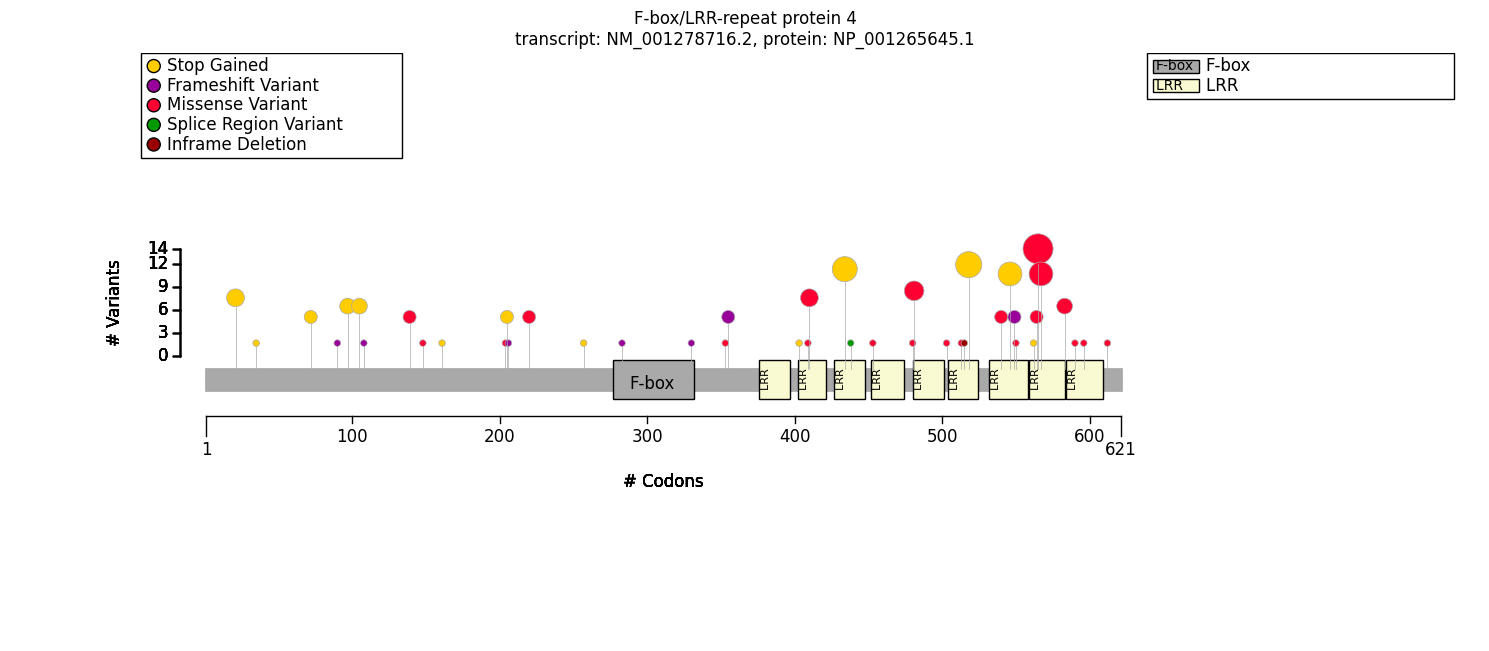

In [18]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)

fbxl4_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fbxl4_fig.tight_layout()

In [19]:
from gpsea.view import CohortVariantViewer
cvv = CohortVariantViewer(tx_id=mane_tx_id)
cvv.process(cohort=cohort)

Variant key,Variant (cDNA),Variant (protein),Overlapping Exons,Effects,Count
6_98875419_98875419_T_C,c.1698A>G,p.Ile566Met,9,missense,14
6_98875562_98875562_G_A,c.1555C>T,p.Gln519Ter,9,stop gained,10
6_98874441_98874441_C_G,c.1703G>C,p.Gly568Ala,10,"missense, splice region",8
6_98875474_98875476_TCA_T,c.1641_1642del,p.Cys547Ter,9,"stop gained, frameshift",8
6_98899282_98899282_G_A,c.1303C>T,p.Arg435Ter,7,stop gained,6
6_98875673_98875673_G_A,c.1444C>T,p.Arg482Trp,9,missense,5
6_98926925_98926925_G_A,c.64C>T,p.Arg22Ter,4,stop gained,4
6_98899353_98899353_C_T,c.1232G>A,p.Cys411Tyr,7,missense,4
6_98926697_98926697_G_A,c.292C>T,p.Arg98Ter,4,stop gained,3
6_98926673_98926673_G_A,c.316C>T,p.Gln106Ter,4,stop gained,3


In [20]:
from gpsea.view import ProteinVariantViewer
pvviewer = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvviewer.process(cohort=cohort)

Name,Type,Coordinates,Count,Variants
F-box,DOMAIN,277 - 332,2,p.Leu332ThrfsTer3; p.Pro284LeufsTer7
LRR 1,REPEAT,376 - 397,0,
LRR 2,REPEAT,402 - 421,6,p.Cys411Tyr; p.Ser410Phe; p.Gln404Ter
LRR 3,REPEAT,427 - 448,10,p.Arg435Gln; p.Glu439=; p.Arg435Leu; p.Arg435Ter
LRR 4,REPEAT,452 - 474,1,p.Gln454Pro
LRR 5,REPEAT,480 - 501,6,p.Arg482Trp; p.Leu481Pro
LRR 6,REPEAT,504 - 524,12,p.Gln519Ter; p.Trp514Gly; p.Pro516_Ser521del
LRR 7,REPEAT,532 - 558,13,p.Asp550HisfsTer2; p.Thr541Ile; p.Ile551Asn; p.Cys547Ter
LRR 8,REPEAT,559 - 583,25,p.Gln563Ter; p.Gly568Ala; p.Ile566Met; p.Asp565Gly
LRR 9,REPEAT,584 - 609,2,p.Gln597Pro; p.Asp591Gly


# Genotype Phenotype Correlation (GPC) Analysis


In [21]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [22]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import biallelic_predicate, VariantPredicates

missense = VariantPredicates.variant_effect(effect=VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)
missense_predicate = biallelic_predicate(a_predicate=missense, 
                                  b_predicate=~missense,
                                  a_label="missense", 
                                  b_label="other",
                                  partitions=((1,2), (0,)))


In [23]:
missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=missense_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,38
HMF03,Skipping term because of a child term with the same individual counts,4
HMF08,Skipping general term,88
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,201


In [24]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group                                       missense/other OR other/other  \
                                                                           Count   
Feeding difficulties [HP:0011968]                                          23/24   
Cryptorchidism [HP:0000028]                                                 7/16   
Microcephaly [HP:0000252]                                                  20/34   
Short stature [HP:0004322]                                                 18/28   
Failure to thrive [HP:0001508]                                             21/30   
Ventriculomegaly [HP:0002119]                                              12/28   
Hyperammonemia [HP:0001987]                                                12/31   
Decreased body weight [HP:0004325]                                         28/28   
Morphological central nervous system abnormalit...                         48/48   
Abnormal cerebral morphology [HP:0002060]                                  27/27   
Abnormal brain morphology [HP:0012443]                                     43/43   
Global brain atrophy [HP:0002283]                                          22/22   
Brain atrophy [HP:0012444]                                                 35/35   
Aplasia/Hypoplasia involving the central nervou...                         39/39   
Cerebral atrophy [HP:0002059]                                              17/31   
Hypotonia [HP:0001252]                                                     45/48   
Abnormal muscle tone [HP:0003808]                                          45/45   
Small for gestational age [HP:0001518]                                     17/27   
Increased serum lactate [HP:0002151]                                       54/54   
Acidosis [HP:0001941]                                                      55/55   
Global developmental delay [HP:0001263]                                    28/28   
Abnormal axial skeleton morphology [HP:0009121]                            26/26   

Allele group                                               missense/missense  \
                                                   Percent             Count   
Feeding difficulties [HP:0011968]                      96%             13/27   
Cryptorchidism [HP:0000028]                            44%              4/30   
Microcephaly [HP:0000252]                              59%              7/24   
Short stature [HP:0004322]                             64%              9/25   
Failure to thrive [HP:0001508]                         70%             11/25   
Ventriculomegaly [HP:0002119]                          43%              5/25   
Hyperammonemia [HP:0001987]                            39%             12/22   
Decreased body weight [HP:0004325]                    100%             14/14   
Morphological central nervous system abnormalit...    100%             30/30   
Abnormal cerebral morphology [HP:0002060]             100%             20/20   
Abnormal brain morphology [HP:0012443]                100%             30/30   
Global brain atrophy [HP:0002283]                     100%             17/17   
Brain atrophy [HP:0012444]                            100%             24/24   
Aplasia/Hypoplasia involving the central nervou...    100%             29/29   
Cerebral atrophy [HP:0002059]                          55%             13/25   
Hypotonia [HP:0001252]                                 94%             34/36   
Abnormal muscle tone [HP:0003808]                     100%             34/34   
Small for gestational age [HP:0001518]                 63%             11/17   
Increased serum lactate [HP:0002151]                  100%             38/38   
Acidosis [HP:0001941]                                 100%             38/38   
Global developmental delay [HP:0001263]               100%             24/24   
Abnormal axial skeleton morphology [HP:0009121]       100%             14/14   

Allele group                                                  

In [26]:
from gpsea.model.genome import Region

# LRR 1
lrr_domains = list() # LRR 1 to 9
for i in range(1,10):
    label = f"LRR {i}"
    is_lrr = VariantPredicates.protein_feature(feature_id=label, protein_metadata=protein_meta)
    lrr_domains.append(is_lrr)

lrr = VariantPredicates.any(lrr_domains)

lrr_predicate = biallelic_predicate(a_predicate=lrr, 
                                    b_predicate=~lrr,
                                    a_label="LRR domain", 
                                    b_label="other",
                                  partitions=((0,1), (2,)))
lrr_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=lrr_predicate,
    pheno_predicates=pheno_predicates,
)

summarize_hpo_analysis(hpo=hpo, result=lrr_result)

Allele group                                       LRR domain/LRR domain OR LRR domain/other  \
                                                                                       Count   
Feeding difficulties [HP:0011968]                                                      24/39   
Wide nasal bridge [HP:0000431]                                                          8/53   
Nystagmus [HP:0000639]                                                                  6/46   
Cryptorchidism [HP:0000028]                                                             7/38   
Enlarged cisterna magna [HP:0002280]                                                    8/37   
Failure to thrive [HP:0001508]                                                         24/44   
Cerebral atrophy [HP:0002059]                                                          20/41   
Small for gestational age [HP:0001518]                                                 23/34   
Hyperammonemia [HP:0001987]                                                            18/43   
Hypotonia [HP:0001252]                                                                 60/65   
Short stature [HP:0004322]                                                             20/41   
Microcephaly [HP:0000252]                                                              20/45   
Decreased body weight [HP:0004325]                                                     32/32   
Morphological central nervous system abnormalit...                                     59/59   
Abnormal cerebral morphology [HP:0002060]                                              34/34   
Abnormal brain morphology [HP:0012443]                                                 55/55   
Global brain atrophy [HP:0002283]                                                      32/32   
Brain atrophy [HP:0012444]                                                             44/44   
Aplasia/Hypoplasia involving the central nervou...                                     51/51   
Abnormal muscle tone [HP:0003808]                                                      60/60   
Increased serum lactate [HP:0002151]                                                   68/68   
Acidosis [HP:0001941]                                                                  69/69   
Global developmental delay [HP:0001263]                                                37/37   
Abnormal axial skeleton morphology [HP:0009121]                                        28/28   

Allele group                                               other/other  \
                                                   Percent       Count   
Feeding difficulties [HP:0011968]                      62%       12/12   
Wide nasal bridge [HP:0000431]                         15%        7/15   
Nystagmus [HP:0000639]                                 13%        6/13   
Cryptorchidism [HP:0000028]                            18%         4/8   
Enlarged cisterna magna [HP:0002280]                   22%        5/12   
Failure to thrive [HP:0001508]                         55%        8/11   
Cerebral atrophy [HP:0002059]                          49%       10/15   
Small for gestational age [HP:0001518]                 68%        5/10   
Hyperammonemia [HP:0001987]                            42%        6/10   
Hypotonia [HP:0001252]                                 92%       19/19   
Short stature [HP:0004322]                             49%        7/12   
Microcephaly [HP:0000252]                              44%        7/13   
Decreased body weight [HP:0004325]                    100%       10/10   
Morphological central nervous system abnormalit...    100%       19/19   
Abnormal cerebral morphology [HP:0002060]             100%       13/13   
Abnormal brain morphology [HP:0012443]                100%       18/18   
Global brain atrophy [HP:0002283]                     100%         7/7   
Brain atrophy [HP:0012444]                            100%       15/15   
Aplasia/Hypoplasia invo

In [ ]:
# N-terminal, located N-terminal to the F-box domain: 277-332

nterm = VariantPredicates.region(region=Region(start=1, end=276), tx_id=mane_tx_id)
nterm_predicate = biallelic_predicate(a_predicate=lrr, 
                                    b_predicate=~lrr,
                                    a_label="N-Terminal (1-276)", 
                                    b_label="other",
                                  partitions=((0,1), (2,)))
nterm_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=nterm_predicate,
    pheno_predicates=pheno_predicates,
)

summarize_hpo_analysis(hpo=hpo, result=nterm_result)

Allele group                                       LRR domain/LRR domain OR LRR domain/other  \
                                                                                       Count   
Feeding difficulties [HP:0011968]                                                      24/39   
Wide nasal bridge [HP:0000431]                                                          8/53   
Nystagmus [HP:0000639]                                                                  6/46   
Cryptorchidism [HP:0000028]                                                             7/38   
Enlarged cisterna magna [HP:0002280]                                                    8/37   
Failure to thrive [HP:0001508]                                                         24/44   
Cerebral atrophy [HP:0002059]                                                          20/41   
Small for gestational age [HP:0001518]                                                 23/34   
Hyperammonemia [HP:0001987]                                                            18/43   
Hypotonia [HP:0001252]                                                                 60/65   
Short stature [HP:0004322]                                                             20/41   
Microcephaly [HP:0000252]                                                              20/45   
Decreased body weight [HP:0004325]                                                     32/32   
Morphological central nervous system abnormalit...                                     59/59   
Abnormal cerebral morphology [HP:0002060]                                              34/34   
Abnormal brain morphology [HP:0012443]                                                 55/55   
Global brain atrophy [HP:0002283]                                                      32/32   
Brain atrophy [HP:0012444]                                                             44/44   
Aplasia/Hypoplasia involving the central nervou...                                     51/51   
Abnormal muscle tone [HP:0003808]                                                      60/60   
Increased serum lactate [HP:0002151]                                                   68/68   
Acidosis [HP:0001941]                                                                  69/69   
Global developmental delay [HP:0001263]                                                37/37   
Abnormal axial skeleton morphology [HP:0009121]                                        28/28   

Allele group                                               other/other  \
                                                   Percent       Count   
Feeding difficulties [HP:0011968]                      62%       12/12   
Wide nasal bridge [HP:0000431]                         15%        7/15   
Nystagmus [HP:0000639]                                 13%        6/13   
Cryptorchidism [HP:0000028]                            18%         4/8   
Enlarged cisterna magna [HP:0002280]                   22%        5/12   
Failure to thrive [HP:0001508]                         55%        8/11   
Cerebral atrophy [HP:0002059]                          49%       10/15   
Small for gestational age [HP:0001518]                 68%        5/10   
Hyperammonemia [HP:0001987]                            42%        6/10   
Hypotonia [HP:0001252]                                 92%       19/19   
Short stature [HP:0004322]                             49%        7/12   
Microcephaly [HP:0000252]                              44%        7/13   
Decreased body weight [HP:0004325]                    100%       10/10   
Morphological central nervous system abnormalit...    100%       19/19   
Abnormal cerebral morphology [HP:0002060]             100%       13/13   
Abnormal brain morphology [HP:0012443]                100%       18/18   
Global brain atrophy [HP:0002283]                     100%         7/7   
Brain atrophy [HP:0012444]                            100%       15/15   
Aplasia/Hypoplasia invo

In [35]:
from gpsea.analysis.predicate.genotype import sex_predicate

mf_result =  analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=sex_predicate(),
    pheno_predicates=pheno_predicates,
)

summarize_hpo_analysis(hpo=hpo, result=mf_result)

Sex                                                FEMALE           MALE  \
                                                    Count Percent  Count   
Short stature [HP:0004322]                          14/20     70%  13/33   
Feeding difficulties [HP:0011968]                   18/21     86%  18/30   
Failure to thrive [HP:0001508]                      16/22     73%  16/33   
Ventriculomegaly [HP:0002119]                        9/19     47%   8/34   
Hypotonia [HP:0001252]                              32/32    100%  47/52   
Microcephaly [HP:0000252]                           12/20     60%  15/38   
Small for gestational age [HP:0001518]              14/19     74%  14/25   
Decreased body weight [HP:0004325]                  20/20    100%  22/22   
Morphological central nervous system abnormalit...  33/33    100%  45/45   
Abnormal cerebral morphology [HP:0002060]           17/17    100%  30/30   
Abnormal brain morphology [HP:0012443]              29/29    100%  44/44   
Global brain atrophy [HP:0002283]                   13/13    100%  26/26   
Brain atrophy [HP:0012444]                          22/22    100%  37/37   
Aplasia/Hypoplasia involving the central nervou...  25/25    100%  43/43   
Cerebral atrophy [HP:0002059]                       11/20     55%  19/36   
Abnormal muscle tone [HP:0003808]                   32/32    100%  47/47   
Increased serum lactate [HP:0002151]                35/35    100%  57/57   
Acidosis [HP:0001941]                               36/36    100%  57/57   
Hyperammonemia [HP:0001987]                         10/21     48%  14/32   
Global developmental delay [HP:0001263]             22/22    100%  30/30   
Abnormal axial skeleton morphology [HP:0009121]     15/15    100%  25/25   

Sex                                                                            \
                                                   Percent Corrected p values   
Short stature [HP:0004322]                             39%           0.600507   
Feeding difficulties [HP:0011968]                      60%           0.600507   
Failure to thrive [HP:0001508]                         48%           0.600507   
Ventriculomegaly [HP:0002119]                          24%           0.600507   
Hypotonia [HP:0001252]                                 90%           0.600507   
Microcephaly [HP:0000252]                              39%           0.600507   
Small for gestational age [HP:0001518]                 56%           1.000000   
Decreased body weight [HP:0004325]                    100%           1.000000   
Morphological central nervous system abnormalit...    100%           1.000000   
Abnormal cerebral morphology [HP:0002060]             100%           1.000000   
Abnormal brain morphology [HP:0012443]                100%           1.000000   
Global brain atrophy [HP:0002283]                     100%           1.000000   
Brain atrophy [HP:0012444]                            100%           1.000000   
Aplasia/Hypoplasia involving the central nervou...    100%           1.000000   
Cerebral atrophy [HP:0002059]                          53%           1.000000   
Abnormal muscle tone [HP:0003808]                     100%           1.000000   
Increased serum lactate [HP:0002151]                  100%           1.000000   
Acidosis [HP:0001941]                                 100%           1.000000   
Hyperammonemia [HP:0001987]                            44%           1.000000   
Global developmental delay [HP:0001263]               100%           1.000000   
Abnormal axial skeleton morphology [HP:0009121]       100%           1.000000   

Sex                                                           
                                                    p values  
Short stature [HP:0004322]                          0.047270  
Feeding difficulties [HP:0011968]                   0.064168  
Failure to thrive [HP:0001508]                      0.097738  
Ventriculomegaly [HP:0002119]                       0.123855  
Hypotonia

In [54]:
from gpsea.analysis.temporal.endpoint import death

from gpsea.analysis.temporal.stats import LogRankTest
survival_statistic = LogRankTest()
from gpsea.analysis.temporal import SurvivalAnalysis
survival_analysis = SurvivalAnalysis(
    statistic=survival_statistic,
)
missense_mortality_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_predicate=missense_predicate,
    endpoint=death() 
)
print(f"survival analysis p={missense_mortality_result.pval:.5f}")

survival analysis p=0.08031


Text(5500, 0.6, '$p=0.0803$')

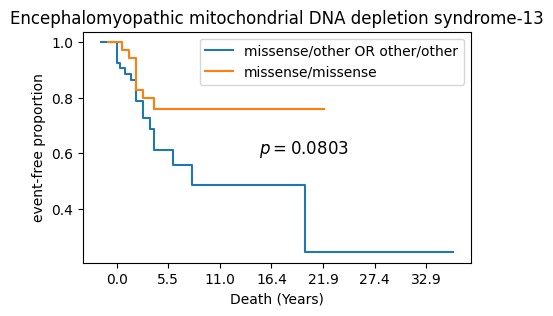

In [55]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

onset_fig, ax = plt.subplots(figsize=(5, 3))
missense_mortality_result.plot_kaplan_meier_curves(ax=ax)
def days_to_years(x, pos):
    return f"{x / 365.25:.1f}"


ax.xaxis.set_major_formatter(FuncFormatter(days_to_years))
ax.set_xlabel("Death (Years)")
ax.set_ylabel("event-free proportion")
ax.set_title("Encephalomyopathic mitochondrial DNA depletion syndrome-13")
s = f"p={missense_mortality_result.pval:.4f}"
ax.text(x=5500, y=0.6, s=f"${s}$", fontsize=12)

In [57]:
from gpsea.analysis.temporal.endpoint import disease_onset

d_onset = disease_onset("OMIM:615471")
missense_onset_result = survival_analysis.compare_genotype_vs_survival(
    cohort=cohort,
    gt_predicate=missense_predicate,
    endpoint=d_onset
)
print(f"survival analysis p={missense_onset_result.pval:.5f}")

survival analysis p=0.03066


Text(2500, 0.6, '$p=0.0307$')

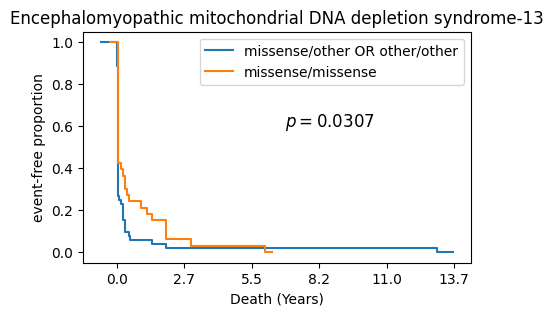

In [59]:
onset_fig, ax = plt.subplots(figsize=(5, 3))
missense_onset_result.plot_kaplan_meier_curves(ax=ax)

ax.xaxis.set_major_formatter(FuncFormatter(days_to_years))
ax.set_xlabel("Death (Years)")
ax.set_ylabel("event-free proportion")
ax.set_title("Encephalomyopathic mitochondrial DNA depletion syndrome-13")
s = f"p={missense_onset_result.pval:.4f}"
ax.text(x=2500, y=0.6, s=f"${s}$", fontsize=12)

# Summary

In [63]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

m_results = (
    GPAnalysisResultSummary.from_mono(
        result=missense_onset_result
    ),
     GPAnalysisResultSummary.from_mono(
        result=missense_mortality_result
    )
)


FET_results = (
   GPAnalysisResultSummary.from_multi(
        result=missense_result,
    
    ),
    GPAnalysisResultSummary.from_multi(
        result=lrr_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=nterm_result,
    ),
     GPAnalysisResultSummary.from_multi(
        result=mf_result,
    ),

)


report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=FET_results,
                             mono_results=m_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,)

In [64]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [65]:
summarizer.process_latex(report=report, protein_fig=fbxl4_fig, stats_fig=onset_fig)

Figure saved to ../../supplement/img/FBXL4_protein_diagram-draft.pdf
Figure saved to ../../supplement/img/FBXL4_stats-draft.pdf
Output to ../../supplement/tex/FBXL4_summary_draft.tex
